<a href="https://colab.research.google.com/github/MEnisSen/indian_pines_cnn_tf/blob/main/HSI_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **DATA**

In [ ]:
!pip install -U -q scipy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.io import loadmat

#data_url = "https://github.com/MEnisSen/indian_pines_cnn_tf/blob/main/Indian_pines.mat"
#data_url_corrected = "https://github.com/MEnisSen/indian_pines_cnn_tf/blob/7df65372911f8c40208f884954569fb717b673c8/Indian_pines_corrected.mat"
#data_url_groundTruth = "https://github.com/MEnisSen/indian_pines_cnn_tf/blob/7df65372911f8c40208f884954569fb717b673c8/Indian_pines_gt.mat"

#!wget https://github.com/MEnisSen/indian_pines_cnn_tf/blob/7df65372911f8c40208f884954569fb717b673c8/Indian_pines_gt.mat
#!wget https://github.com/MEnisSen/indian_pines_cnn_tf/blob/7df65372911f8c40208f884954569fb717b673c8/Indian_pines_corrected.mat
#!mv Indian_pines_gt.mat\?raw\=true Indian_pines_gt.mat

#dataset = loadmat('Indian_pines.mat')['indian_pines']
dataset_corrected = loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
dataset_gt = loadmat('Indian_pines_gt.mat')['indian_pines_gt']

In [ ]:
dataset_corrected = np.array(dataset_corrected)
dataset_gt = np.array(dataset_gt)

dataset_corrected = np.swapaxes(dataset_corrected, 0, 1)
dataset_corrected = np.swapaxes(dataset_corrected, 0, 2)

In [ ]:
print("\nShape of corrected data set :",dataset_corrected.shape,"\nShape of ground truth :",dataset_gt.shape)


Shape of corrected data set : (200, 145, 145) 
Shape of ground truth : (145, 145)


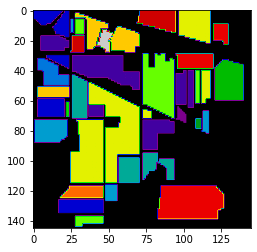

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.imshow(dataset_gt, cmap='nipy_spectral')

In [ ]:
a = dataset_gt.shape[1]

data = np.zeros((a**2,200))
labels = np.zeros((a**2,1))

for i in range(a):
  for j in range(a):
    data[i*a+j] = dataset_corrected[:, i, j]
    labels[i*a+j] = dataset_gt[i,j]

In [ ]:
np.unique(labels)

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16.])

In [ ]:
non_zeros = np.where(labels!=0)[0]
data = data[non_zeros]
labels = labels[non_zeros]

In [ ]:
np.unique(labels)

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16.])

In [ ]:
print("Number of data samples: ",data.shape)

Number of data samples:  (10249, 200)


In [ ]:
from sklearn.model_selection import train_test_split

(x_train, x_test, y_train, y_test) = train_test_split(data, labels, test_size=0.5)
print("Number of train samples: ",y_train.shape[0], "\nNumber of test samples: ",y_test.shape[0])

Number of train samples:  5124 
Number of test samples:  5125


## **1D CNN**

In [ ]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

model = tf.keras.models.Sequential([
      tf.keras.layers.Conv1D(64, 3, activation='relu', input_shape=(200,1)),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Conv1D(128, 3, activation='relu'),
      tf.keras.layers.MaxPooling1D(2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(256, activation='relu'),
      #tf.keras.layers.Dropout(0.1),
      tf.keras.layers.Dense(17, activation='softmax')
  ])

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss = 'sparse_categorical_crossentropy',
              metrics=['accuracy']) 

history = model.fit(x_train, y_train, epochs=50)

Epoch 1/50
161/161 [==============================] - 34s 39ms/step - loss: 69.0007 - accuracy: 0.2879
Epoch 2/50
161/161 [==============================] - 6s 39ms/step - loss: 2.3037 - accuracy: 0.3755
Epoch 3/50
161/161 [==============================] - 6s 39ms/step - loss: 2.6407 - accuracy: 0.4030
Epoch 4/50
161/161 [==============================] - 6s 40ms/step - loss: 1.6663 - accuracy: 0.4358
Epoch 5/50
161/161 [==============================] - 6s 39ms/step - loss: 1.6047 - accuracy: 0.4463
Epoch 6/50
161/161 [==============================] - 6s 39ms/step - loss: 1.6417 - accuracy: 0.4645
Epoch 7/50
161/161 [==============================] - 6s 39ms/step - loss: 1.5064 - accuracy: 0.4852
Epoch 8/50
161/161 [==============================] - 6s 39ms/step - loss: 1.6079 - accuracy: 0.5115
Epoch 9/50
161/161 [==============================] - 6s 39ms/step - loss: 1.3206 - accuracy: 0.5082
Epoch 10/50
161/161 [==============================] - 7s 43ms/step - loss: 1.4002 - accu

In [ ]:
model.evaluate(x_test, y_test, batch_size=128)

41/41 [==============================] - 1s 29ms/step - loss: 1.2941 - accuracy: 0.5309


[1.2940926551818848, 0.5309268236160278]

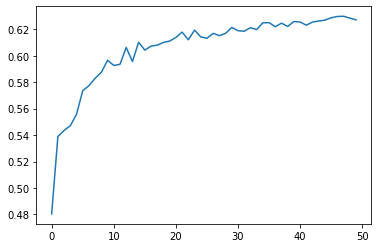

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(history.history['accuracy'])

In [ ]:
test_num = 3
preds = model.predict(x_test[:test_num])
print("Predicted value :", preds, ", Actual value :", y_test[test_num])

1/1 [==============================] - 0s 19ms/step
Predicted value : [[9.4122535e-01 9.2422142e-13 2.8473462e-08 9.7559374e-09 2.7819498e-08
  9.7825468e-05 3.9223727e-02 4.3598403e-16 1.8713302e-10 6.4539276e-13
  2.1288836e-10 1.2386432e-08 2.0156884e-08 1.8452934e-03 7.5731669e-03
  1.0034672e-02 5.8995258e-09]
 [7.0605785e-02 9.8982089e-16 3.7925366e-02 1.5752170e-02 8.6298140e-05
  1.0768800e-11 2.2635514e-10 8.1918054e-14 1.8007132e-10 1.7319938e-17
  4.7737879e-01 3.8746843e-01 9.8126223e-03 6.4477767e-14 2.5216964e-12
  2.2094865e-12 9.7055605e-04]
 [3.5543704e-01 1.6409531e-05 8.8146985e-02 1.6687590e-01 7.8062855e-02
  3.5232219e-03 1.7187778e-03 7.8471651e-04 1.0234145e-03 2.5004701e-11
  3.0938813e-02 7.9448543e-02 1.9044681e-01 5.9099275e-08 9.3248291e-06
  8.2792685e-04 2.7391443e-03]] , Actual value : [3.]
